# Training and testing of the Distilroberta model on the train dataset (Reddit book reviews)

In [1]:
from transformers import DataCollatorWithPadding,TrainingArguments, Trainer, AutoTokenizer, RobertaForSequenceClassification
from transformers import AutoModelForSequenceClassification
from datasets import load_dataset
from huggingface_hub import notebook_login
import numpy as np
import evaluate
import torch._dynamo
from scipy.special import softmax
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
import time


In [2]:
torch.manual_seed(42)

In [3]:
train_dataset = load_dataset("csv", data_files="books_train.csv")["train"]
test_dataset = load_dataset("csv", data_files="books_test.csv")["train"]

In [4]:
tokenizer = AutoTokenizer.from_pretrained('distilroberta-base')

In [5]:
device = torch.device('cuda')

In [6]:
def preprocess_function(examples):
    inputs = tokenizer(examples["body"], truncation=True).to(device)
    return inputs
 
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

In [7]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [8]:
model = RobertaForSequenceClassification.from_pretrained('distilroberta-base', num_labels=2).to(device)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Identifying the metrics for training the model¶

In [9]:
def compute_metrics(eval_pred):
   load_precision = evaluate.load("precision")
   load_f1 = evaluate.load("f1")
   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   precision = load_precision.compute(predictions=predictions, references=labels)
   f1 = load_f1.compute(predictions=predictions, references=labels)
   return {"precision": precision, "f1": f1}

In [10]:
repo_name = "finetuning-DistilRoberta-Reddit-books"
training_args = TrainingArguments(
   output_dir=repo_name,
   learning_rate=2e-5,
   per_device_train_batch_size=2,
   per_device_eval_batch_size=2,
   num_train_epochs=7,
   weight_decay=0.05,
   # max_steps = 10,
   save_strategy="no",
   push_to_hub=False,
   logging_steps=10,  # Print loss every 10 steps
   log_level="info",
)
 
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)


/tmp/ipykernel_13622/4175164034.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [11]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: body. If body are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 200
  Num Epochs = 7
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 700
  Number of trainable parameters = 82,119,938


Step,Training Loss
10,0.704100
20,0.464000
30,0.645500
40,1.130700
50,1.390200
60,0.612500
70,1.529600
80,0.862200
90,0.691600
100,0.513000




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=700, training_loss=0.39130142328528955, metrics={'train_runtime': 64.869, 'train_samples_per_second': 21.582, 'train_steps_per_second': 10.791, 'total_flos': 124792051295592.0, 'train_loss': 0.39130142328528955, 'epoch': 7.0})

In [12]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: body. If body are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 100
  Batch size = 2


{'eval_loss': 1.3915847539901733,
 'eval_precision': {'precision': 0.8676470588235294},
 'eval_f1': {'f1': 0.8428571428571429},
 'eval_runtime': 2.7601,
 'eval_samples_per_second': 36.23,
 'eval_steps_per_second': 18.115,
 'epoch': 7.0}

## Calculating accuracy

In [13]:
inputs = tokenizer(test_dataset['body'], truncation=True, return_tensors="pt", padding=True).to("cpu")
model_cpu = model.to("cpu")
with torch.no_grad():
    logits = model_cpu(**inputs).logits


predictions = np.argmax(logits, axis=-1)
labels = test_dataset["label"]
load_accuracy = evaluate.load("accuracy")
accuracy = load_accuracy.compute(predictions=predictions, references=labels)
print({"accuracy": accuracy})

{'accuracy': {'accuracy': 0.78}}


In [14]:
predictions

tensor([0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
        1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
        0, 1, 1, 1])

### Accuracy is 0.78, F1-score is 0.84, precision is 0.87

In [15]:
#logits of the inference on the testing data
Reddit_roberta_logits = logits.numpy()

In [16]:
y_true = np.array(test_dataset["label"])
y_score_baseline = np.ones(y_true.shape)
baseline_precision = precision_score(y_true, y_score_baseline, zero_division=1)
baseline_recall = recall_score(y_true, y_score_baseline, zero_division=1)

## PR curve: calculating precision and recall

In [17]:
y_true = np.array(test_dataset["label"])
Reddit_roberta_precision = []
Reddit_roberta_recall = []
Reddit_roberta_probabilities = softmax(Reddit_roberta_logits, axis=1)
threshold = list(np.arange(0.0, 1, 0.001))
threshold.append(1-1e-5)
for t in threshold:
    y_scores = (Reddit_roberta_probabilities[:, 1] > t).astype(int)
    Reddit_roberta_precision.append(precision_score(y_true, y_scores, zero_division=1))
    Reddit_roberta_recall.append(recall_score(y_true, y_scores, zero_division=1))

Reddit_roberta_precision.append(1)
Reddit_roberta_recall.append(0)

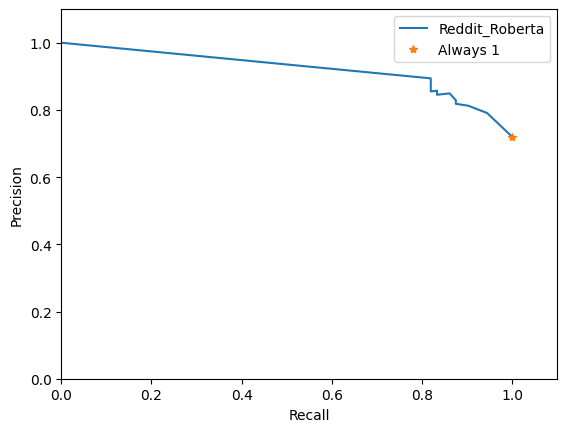

In [18]:
fig, ax = plt.subplots()
ax.plot(Reddit_roberta_recall, Reddit_roberta_precision, '-', label="Reddit_Roberta")
ax.plot([baseline_recall], [baseline_precision], '*', label='Always 1')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_xlim((0, 1.1))
ax.set_ylim((0, 1.1))
ax.legend()

In [19]:
np.savetxt("Reddit_roberta_logits.csv", Reddit_roberta_logits, delimiter = ",")

## Estimating inference time

In [20]:
time_start = time.perf_counter()
model_cpu = model.to("cpu")

for text in test_dataset["body"]:
        request = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to('cpu')
        outputs = model_cpu(**request)

time_end = time.perf_counter()
    
print(f'Took {(time_end - time_start):.3f} seconds')

Took 6.658 seconds
